In [3]:
import torch
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

In [4]:
from datasets import load_dataset
import pandas as pd
import re
import numpy as np
from datasets import Dataset
import matplotlib.pyplot as plt

In [8]:
# Caricamento del dataset, considerando solo raw review All Beauty

df = pd.read_csv("../data/raw/reviews/amazon_beauty_reviews.csv")
df

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,5.0,Such a lovely scent but not overpowering.,This spray is really nice. It smells really go...,[],B00YQ6X8EO,B00YQ6X8EO,AGKHLEW2SOWHNMFQIJGBECAF7INQ,1588687728923,0,True
1,4.0,Works great but smells a little weird.,"This product does what I need it to do, I just...",[],B081TJ8YS3,B081TJ8YS3,AGKHLEW2SOWHNMFQIJGBECAF7INQ,1588615855070,1,True
2,5.0,Yes!,"Smells good, feels great!",[],B07PNNCSP9,B097R46CSY,AE74DYR3QUGVPZJ3P7RFWBGIX7XQ,1589665266052,2,True
3,1.0,Synthetic feeling,Felt synthetic,[],B09JS339BZ,B09JS339BZ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,1643393630220,0,True
4,5.0,A+,Love it,[],B08BZ63GMJ,B08BZ63GMJ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,1609322563534,0,True
...,...,...,...,...,...,...,...,...,...,...
701523,4.0,Four Stars,Conditioner is great shampoo not as I expected,[],B006YUIWKA,B006YUIWKA,AFIXGFVEGLMOTMBTJL7H3VSIETDQ,1478227021000,0,True
701524,1.0,Pretty,Did not work! Used the whole bottle and my hai...,[],B006YUIWKA,B006YUIWKA,AFV7YZFOJF564EZGET5LG45K4QEA,1480908730000,0,False
701525,5.0,Great sunless tanner,Product as expected. Shipping was on time.,[],B06ZZV9MZT,B06ZZV9MZT,AHYDCWDMMVMLBX7FY7M7JKADKRDQ,1590547974067,0,True
701526,5.0,The Crown on top is a Ring!!!,"Not only is it a delicious fragrance, but also...",[],B000HB6VLE,B000HB6VLE,AF6ZIAEN7TQ2WY5ZL77F6JDPV7XQ,1184798209000,4,False


## Pulizia del dataset

### Inizio cleaning

In [ ]:

# 1. Rimpiazza tutte le forme testuali di null con np.nan
for col in ["text", "title"]:
    df[col] = df[col].replace(to_replace=["nan", "NaN", "None", "null", "NULL", ""], value=np.nan)

# 2. Rimuovi righe con valori nulli reali
df = df.dropna(subset=["text", "title", "rating"])

# 3. Convertili in stringa (in caso qualcosa sia ancora float o altro)
df["text"] = df["text"].astype(str)
df["title"] = df["title"].astype(str)

# 4. Elimina righe con solo spazi (o vuote anche dopo strip)
df = df[(df["text"].str.strip() != "") & (df["title"].str.strip() != "")]

# 5. (Opzionale) Rimuovi righe con lunghezza < 5 caratteri
df = df[(df["text"].str.len() > 5) & (df["title"].str.len() > 3)]

# 6. Reset dell'indice
df.reset_index(drop=True, inplace=True)

print(f"Righe rimanenti dopo pulizia: {len(df)}")


Righe rimanenti dopo pulizia: 684236


In [10]:
# Rimozione duplicati sul campo 'text' (case insensitive)
df["text_clean"] = df["text"].str.strip().str.lower()
df = df.drop_duplicates(subset=["text_clean"])
df = df.drop(columns=["text_clean"])

In [11]:
print(len(df))

633861


In [12]:
df

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,5.0,Such a lovely scent but not overpowering.,This spray is really nice. It smells really go...,[],B00YQ6X8EO,B00YQ6X8EO,AGKHLEW2SOWHNMFQIJGBECAF7INQ,1588687728923,0,True
1,4.0,Works great but smells a little weird.,"This product does what I need it to do, I just...",[],B081TJ8YS3,B081TJ8YS3,AGKHLEW2SOWHNMFQIJGBECAF7INQ,1588615855070,1,True
2,5.0,Yes!,"Smells good, feels great!",[],B07PNNCSP9,B097R46CSY,AE74DYR3QUGVPZJ3P7RFWBGIX7XQ,1589665266052,2,True
3,1.0,Synthetic feeling,Felt synthetic,[],B09JS339BZ,B09JS339BZ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,1643393630220,0,True
4,4.0,Pretty Color,The polish was quiet thick and did not apply s...,"[{'attachment_type': 'IMAGE', 'large_image_url...",B00R8DXL44,B00R8DXL44,AGMJ3EMDVL6OWBJF7CA5RGJLXN5A,1598567408138,0,True
...,...,...,...,...,...,...,...,...,...,...
684231,4.0,Four Stars,Conditioner is great shampoo not as I expected,[],B006YUIWKA,B006YUIWKA,AFIXGFVEGLMOTMBTJL7H3VSIETDQ,1478227021000,0,True
684232,1.0,Pretty,Did not work! Used the whole bottle and my hai...,[],B006YUIWKA,B006YUIWKA,AFV7YZFOJF564EZGET5LG45K4QEA,1480908730000,0,False
684233,5.0,Great sunless tanner,Product as expected. Shipping was on time.,[],B06ZZV9MZT,B06ZZV9MZT,AHYDCWDMMVMLBX7FY7M7JKADKRDQ,1590547974067,0,True
684234,5.0,The Crown on top is a Ring!!!,"Not only is it a delicious fragrance, but also...",[],B000HB6VLE,B000HB6VLE,AF6ZIAEN7TQ2WY5ZL77F6JDPV7XQ,1184798209000,4,False


In [9]:

df_metadati = pd.read_csv("../data/raw/metadati/amazon_beauty_metadati.csv")
df_metadati

,main_category,title,average_rating,rating_number,features,description,price,images,videos,store,categories,details,parent_asin,bought_together,subtitle,author
0,All Beauty,"Howard LC0008 Leather Conditioner, 8-Ounce (4-...",4.8,10,[],[],NaN,"{'hi_res': array([None,\n 'https://m.med...","{'title': array([], dtype=object), 'url': arra...",Howard Products,[],"{""Package Dimensions"": ""7.1 x 5.5 x 3 inches; ...",B01CUPMQZE,NaN,NaN,NaN
1,All Beauty,Yes to Tomatoes Detoxifying Charcoal Cleanser ...,4.5,3,[],[],NaN,{'hi_res': array(['https://m.media-amazon.com/...,"{'title': array([], dtype=object), 'url': arra...",Yes To,[],"{""Item Form"": ""Powder"", ""Skin Type"": ""Acne Pro...",B076WQZGPM,NaN,NaN,NaN
2,All Beauty,Eye Patch Black Adult with Tie Band (6 Per Pack),4.4,26,[],[],NaN,"{'hi_res': array([None, None], dtype=object), ...","{'title': array([], dtype=object), 'url': arra...",Levine Health Products,[],"{""Manufacturer"": ""Levine Health Products""}",B000B658RI,NaN,NaN,NaN
3,All Beauty,"Tattoo Eyebrow Stickers, Waterproof Eyebrow, 4...",3.1,102,[],[],NaN,{'hi_res': array(['https://m.media-amazon.com/...,"{'title': array([], dtype=object), 'url': arra...",Cherioll,[],"{""Brand"": ""Cherioll"", ""Item Form"": ""Powder"", ""...",B088FKY3VD,NaN,NaN,NaN
4,All Beauty,Precision Plunger Bars for Cartridge Grips – 9...,4.3,7,['Material: 304 Stainless Steel; Brass tip'\n ...,['The Precision Plunger Bars are designed to w...,NaN,"{'hi_res': array([None], dtype=object), 'large...","{'title': array([], dtype=object), 'url': arra...",Precision,[],"{""UPC"": ""644287689178""}",B07NGFDN6G,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112585,All Beauty,"TOPREETY 24""120gr 3/4 Full Head clip in hair e...",5.0,3,[],[],NaN,{'hi_res': array(['https://m.media-amazon.com/...,"{'title': array([], dtype=object), 'url': arra...",TOPREETY,[],"{""Is Discontinued By Manufacturer"": ""No"", ""Pac...",B077D2Z5RF,NaN,NaN,NaN
112586,All Beauty,"Pets Playmate Pet Grooming Glove,Gentle Deshed...",5.0,1,[],[],NaN,{'hi_res': array(['https://m.media-amazon.com/...,"{'title': array([], dtype=object), 'url': arra...",Pets Playmate,[],"{""Is Discontinued By Manufacturer"": ""No"", ""Pac...",B07DLRYKQZ,NaN,NaN,NaN
112587,All Beauty,[10Pack] Makeup Brushes Set Cosmetics Tools Ki...,4.3,5,[],[],NaN,{'hi_res': array(['https://m.media-amazon.com/...,"{'title': array([], dtype=object), 'url': arra...",RainMakers,[],"{""Brand"": ""RainMakers"", ""Recommended Uses For ...",B07HNP2NTF,NaN,NaN,NaN
112588,All Beauty,Xcoser Pretty Party Anna Wig Hair Tails Hair S...,4.0,9,[],[],NaN,{'hi_res': array(['https://m.media-amazon.com/...,"{'title': array([], dtype=object), 'url': arra...",Xcoser,[],"{""Is Discontinued By Manufacturer"": ""No"", ""Pac...",B00U3OB8PY,NaN,NaN,NaN


In [16]:
df_merged = df.merge(df_metadati, on="parent_asin", how="left")

In [17]:
df_merged.head()

,rating,title_x,text,images_x,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,...,description,price,images_y,videos,store,categories,details,bought_together,subtitle,author
0,5.0,Such a lovely scent but not overpowering.,This spray is really nice. It smells really go...,[],B00YQ6X8EO,B00YQ6X8EO,AGKHLEW2SOWHNMFQIJGBECAF7INQ,1588687728923,0,True,...,"[If given the choice, weÕd leave most telltale...",None,{'hi_res': ['https://m.media-amazon.com/images...,"{'title': ['Best Hair Product For Summer!', 'O...",HERBIVORE,[],"{""Hair Type"": ""Wavy"", ""Material Type Free"": ""D...",None,None,None
1,4.0,Works great but smells a little weird.,"This product does what I need it to do, I just...",[],B081TJ8YS3,B081TJ8YS3,AGKHLEW2SOWHNMFQIJGBECAF7INQ,1588615855070,1,True,...,[],None,{'hi_res': ['https://m.media-amazon.com/images...,"{'title': ['Easy to apply!'], 'url': ['https:/...",Two Goats Apothecary,[],"{""Brand"": ""Two Goats Apothecary"", ""Item Form"":...",None,None,None
2,5.0,Yes!,"Smells good, feels great!",[],B07PNNCSP9,B097R46CSY,AE74DYR3QUGVPZJ3P7RFWBGIX7XQ,1589665266052,2,True,...,[New Road Beauty Paraffin Wax is recommended f...,21.98,{'hi_res': ['https://m.media-amazon.com/images...,{'title': ['Opening the Creamsicle assortment ...,New Road Beauty,[],"{""Package Dimensions"": ""10.5 x 6.4 x 1.6 inche...",None,None,None
3,1.0,Synthetic feeling,Felt synthetic,[],B09JS339BZ,B09JS339BZ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,1643393630220,0,True,...,[Hair Material: Brazilian Virgin Human Hair Bu...,None,{'hi_res': ['https://m.media-amazon.com/images...,"{'title': [], 'url': [], 'user_id': []}",muaowig,[],"{""Brand"": ""muaowig"", ""Material"": ""Human Hair"",...",None,None,None
4,4.0,Pretty Color,The polish was quiet thick and did not apply s...,"[{'attachment_type': 'IMAGE', 'large_image_url...",B00R8DXL44,B00R8DXL44,AGMJ3EMDVL6OWBJF7CA5RGJLXN5A,1598567408138,0,True,...,"[China Glaze Nail Polish, Wanderlust, 1381, .5...",7.1,"{'hi_res': [None], 'large': ['https://m.media-...","{'title': [], 'url': [], 'user_id': []}",China Glaze,[],"{""Brand"": ""China Glaze"", ""Item Form"": ""Liquid""...",None,None,None


In [18]:
df_merged.columns

Index(['rating', 'title_x', 'text', 'images_x', 'asin', 'parent_asin',
       'user_id', 'timestamp', 'helpful_vote', 'verified_purchase',
       'main_category', 'title_y', 'average_rating', 'rating_number',
       'features', 'description', 'price', 'images_y', 'videos', 'store',
       'categories', 'details', 'bought_together', 'subtitle', 'author'],
      dtype='object')

In [19]:
df_merged = df_merged.rename(columns={"title_y": "product_name"})
df_merged = df_merged.rename(columns={"title_x": "title"})

In [20]:
df_merged.columns

Index(['rating', 'title', 'text', 'images_x', 'asin', 'parent_asin', 'user_id',
       'timestamp', 'helpful_vote', 'verified_purchase', 'main_category',
       'product_name', 'average_rating', 'rating_number', 'features',
       'description', 'price', 'images_y', 'videos', 'store', 'categories',
       'details', 'bought_together', 'subtitle', 'author'],
      dtype='object')

In [21]:
# Prendo solo le colonne di interesse
df_merged = df_merged[["rating", "product_name", "title", "text"]]

In [22]:
def clean_text(text):
    text = re.sub(r'<.*?>', '', text)  # Rimuove tag HTML
    text = re.sub(r'[^A-Za-z0-9\s.,!?\'"]+', '', text)  # Rimuove caratteri speciali
    return text.strip()

df_merged.loc[:, 'title'] = df_merged['title'].apply(clean_text)
df_merged.loc[:, 'text'] = df_merged['text'].apply(clean_text)

In [23]:
## Far diventare tutto minuscolo
df_merged.loc[:, 'title'] = df_merged['title'].str.lower()
df_merged.loc[:, 'text'] = df_merged['text'].str.lower()
df_merged.loc[:, 'product_name'] = df_merged['product_name'].str.lower()

In [24]:
df_merged

,rating,product_name,title,text
0,5.0,herbivore - natural sea mist texturizing salt ...,such a lovely scent but not overpowering.,this spray is really nice. it smells really go...
1,4.0,all natural vegan dry shampoo powder - eco fri...,works great but smells a little weird.,"this product does what i need it to do, i just..."
2,5.0,new road beauty - creamsicle - variety 3 pack ...,yes!,"smells good, feels great!"
3,1.0,muaowig ombre body wave bundles 1b grey human ...,synthetic feeling,felt synthetic
4,4.0,"china glaze nail polish, wanderlust 1381",pretty color,the polish was quiet thick and did not apply s...
...,...,...,...,...
633856,4.0,thicker fuller hair weightless shampoo & condi...,four stars,conditioner is great shampoo not as i expected
633857,1.0,thicker fuller hair weightless shampoo & condi...,pretty,did not work! used the whole bottle and my hai...
633858,5.0,neutrogena micro-mist airbrush sunless tan dee...,great sunless tanner,product as expected. shipping was on time.
633859,5.0,vera wang princess,the crown on top is a ring!!!,"not only is it a delicious fragrance, but also..."


In [25]:
import numpy as np
import pandas as pd

def stratified_undersample(df, group_col, text_col, target_count):
    result = []

    for label, group in df.groupby(group_col):
        group = group.copy()
        group["length"] = group[text_col].apply(len)
        group_sorted = group.sort_values("length")

        # Definisci indici
        short_range = group_sorted.iloc[:len(group_sorted)//3]
        medium_range = group_sorted.iloc[len(group_sorted)//3:2*len(group_sorted)//3]
        long_range = group_sorted.iloc[2*len(group_sorted)//3:]

        # Calcola le dimensioni con fallback al min(len, target)
        n_short = min(int(target_count * 0.3), len(short_range))
        n_medium = min(int(target_count * 0.4), len(medium_range))
        n_long = min(target_count - n_short - n_medium, len(long_range))

        short = short_range.sample(n=n_short, random_state=42)
        medium = medium_range.sample(n=n_medium, random_state=42)
        long = long_range.sample(n=n_long, random_state=42)

        balanced = pd.concat([short, medium, long])
        result.append(balanced)

    return pd.concat(result).drop(columns=["length"]).reset_index(drop=True)

# Usa il minimo tra le classi
min_count = df_merged["rating"].value_counts().min()
df_balanced = stratified_undersample(df_merged, group_col="rating", text_col="text", target_count=min_count)


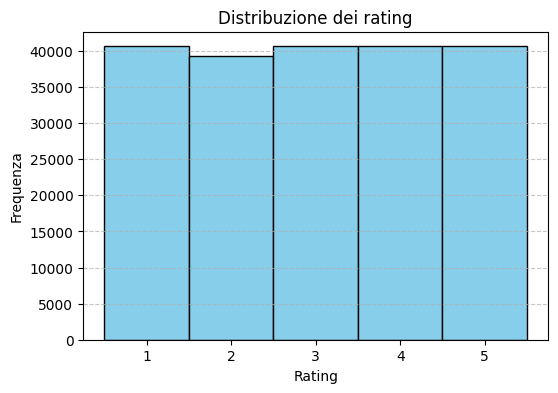

In [26]:
# Assicurati che i rating siano interi
df_balanced["rating"] = df_balanced["rating"].astype(int)

# Istogramma
plt.figure(figsize=(6,4))
plt.hist(df_balanced["rating"], bins=[1,2,3,4,5,6], align='left', edgecolor='black', color='skyblue')

plt.title("Distribuzione dei rating")
plt.xlabel("Rating")
plt.ylabel("Frequenza")
plt.xticks([1, 2, 3, 4, 5])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [27]:
df_balanced

,rating,product_name,title,text
0,1,aigemei peruvian virgin hair body wave burgund...,never again,it was cool for a couple days but after that i...
1,1,"bulk herbs: lavender flower,1 oz",not as described,came as 0.3 oz not 1.0 as described
2,1,sumnacon unisex waterproof travel toiletry bag...,one star,the travel bag smells musty and no matter what...
3,1,makeup brush cleaner wloomm electric makeup br...,one star,does not work as instructed
4,1,hj weave beauty short curly bob human hair wig...,"i wish it looked half as good as the picture, ...","was shorter..ugly, with not many curls. don't ..."
...,...,...,...,...
201796,5,anti aging moisturizer - the best moisturizer ...,very pleased with this anti aging serum! recom...,this product review is for anti aging serum t...
201797,5,hanging toiletry bag for men & women | large t...,"it,s absolutely amazing","it,s amazing for two reasons. 1. design, mater..."
201798,5,evolve satin soc black,keeps hair looking fresh but...,i've worn this a few times around the house an...
201799,5,"neitsi 100% kanekalon fiber 14""(35cm) women's ...",so worth it!,looooove this wig!! i ordered it for my lady j...


In [28]:
# Esempi:
# input_text:  Product: AirPods. Rating: 5 stars.
# target_text: Title: Fantastic\nReview: Best purchase ever!

df_balanced.loc[:, "input_text"] = df_balanced.apply(
    lambda row: f"Product: {row['product_name']}. Rating: {int(row['rating'])} stars.", axis=1)

df_balanced.loc[:, "target_text"] = df_balanced.apply(
    lambda row: f"Title: {row['title']}\nReview: {row['text']}", axis=1)


# Tieni solo queste due colonne
dataset = df_balanced[["input_text", "target_text"]]


In [29]:
dataset

,input_text,target_text
0,Product: aigemei peruvian virgin hair body wav...,Title: never again\nReview: it was cool for a ...
1,"Product: bulk herbs: lavender flower,1 oz. Rat...",Title: not as described\nReview: came as 0.3 o...
2,Product: sumnacon unisex waterproof travel toi...,Title: one star\nReview: the travel bag smells...
3,Product: makeup brush cleaner wloomm electric ...,Title: one star\nReview: does not work as inst...
4,Product: hj weave beauty short curly bob human...,Title: i wish it looked half as good as the pi...
...,...,...
201796,Product: anti aging moisturizer - the best moi...,Title: very pleased with this anti aging serum...
201797,Product: hanging toiletry bag for men & women ...,"Title: it,s absolutely amazing\nReview: it,s a..."
201798,Product: evolve satin soc black. Rating: 5 stars.,Title: keeps hair looking fresh but...\nReview...
201799,"Product: neitsi 100% kanekalon fiber 14""(35cm)...",Title: so worth it!\nReview: looooove this wig...


In [30]:
import mlflow
from dagshub import dagshub_logger
import os
from dotenv import load_dotenv

load_dotenv()

mlflow.set_tracking_uri(os.getenv("MLFLOW_TRACKING_URI"))
mlflow.set_experiment("multi-class-comparison")

<Experiment: artifact_location='mlflow-artifacts:/b2dd1ca643c046919d1e0b5be5ba9906', creation_time=1749214029684, experiment_id='4', last_update_time=1749214029684, lifecycle_stage='active', name='multi-class-comparison', tags={}>

## Train tiny-t5

In [ ]:
import mlflow
import mlflow.transformers
import yaml
import json
from transformers import (
    AutoTokenizer, AutoModelForSeq2SeqLM,
    DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer,
    EarlyStoppingCallback
)
from datasets import Dataset

# Carica i parametri da params.yaml
with open("params.yaml") as f:
    params = yaml.safe_load(f)

t5_params = params["t5"]

# Inizia un esperimento MLflow
mlflow.set_experiment("t5-small-finetuning")

with mlflow.start_run(run_name="t5-small-finetuning-run") as run:
    # 1. Carica tokenizer e modello T5-small
    tokenizer = AutoTokenizer.from_pretrained("t5-small")
    model = AutoModelForSeq2SeqLM.from_pretrained("t5-small")
    data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

 
    dataset = Dataset.from_pandas(dataset[["input_text", "target_text"]])
    dataset = dataset.map(lambda x: {
        "input_text": "generate: " + x["input_text"],
        "target_text": x["target_text"]
    })

    # 3. Split train/test
    dataset_split = dataset.train_test_split(test_size=0.3, seed=42)
    train_dataset = dataset_split["train"]
    test_dataset = dataset_split["test"]

    # 4. Tokenizzazione
    def tokenize(example):
        model_inputs = tokenizer(
            example["input_text"],
            max_length=256,
            padding="max_length",
            truncation=True
        )
        with tokenizer.as_target_tokenizer():
            labels = tokenizer(
                example["target_text"],
                max_length=256,
                padding="max_length",
                truncation=True
            )["input_ids"]
        model_inputs["labels"] = [
            (token if token != tokenizer.pad_token_id else -100)
            for token in labels
        ]
        return model_inputs

    tokenized_train = train_dataset.map(tokenize, batched=True)
    tokenized_test = test_dataset.map(tokenize, batched=True)
    tokenized_train.set_format("torch")
    tokenized_test.set_format("torch")

    # 5. TrainingArguments
    training_args = Seq2SeqTrainingArguments(
        output_dir="./t5-small-finetuned",
        per_device_train_batch_size=t5_params["batch_size_train"],
        per_device_eval_batch_size=t5_params["batch_size_eval"],
        gradient_accumulation_steps=1,
        num_train_epochs=t5_params["epochs"],
        evaluation_strategy="epoch",
        save_strategy="epoch",
        save_total_limit=2,
        logging_dir="./logs",
        logging_steps=20,
        load_best_model_at_end=True,
        report_to="none",
        metric_for_best_model="loss",
        fp16=True,
        learning_rate=t5_params["learning_rate"],
        weight_decay=t5_params["weight_decay"],
        warmup_steps=t5_params["warmup_steps"],
        lr_scheduler_type=t5_params["lr_scheduler_type"]
    )

    # 6. Trainer
    trainer = Seq2SeqTrainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_test,
        tokenizer=tokenizer,
        data_collator=data_collator,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
    )

    # 7. Log parametri in MLflow
    mlflow.log_params(t5_params)

    # 8. Tracking automatico con MLflow Transformers
    mlflow.transformers.autolog(log_models=True)

    # Avvia training
    trainer.train()

    # 9. Salva modello e tokenizer finali
    trainer.save_model("./t5-small-finetuned/final_model")
    tokenizer.save_pretrained("./t5-small-finetuned/final_model")

    # 10. Log modello finale come artifact in MLflow
    mlflow.log_artifacts("./t5-small-finetuned/final_model", artifact_path="final_model")


In [31]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# 🔁 Cambia questo path con la directory reale sul tuo sistema
model_dir = r"./t5-small-finetuned/final_model"

# Carica modello e tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_dir)
model = AutoModelForSeq2SeqLM.from_pretrained(model_dir)

# 🔤 Esempio di input nello stesso formato usato in training
product_name = "lipstick"
rating = 2
input_prompt = f"Generate a review of a {product_name} with a rating of {rating} stars."

# Tokenizza
inputs = tokenizer(input_prompt, return_tensors="pt", truncation=True)

# Generazione
outputs = model.generate(
    **inputs,
    max_length=128,
    do_sample=True,
    top_k=50,
    top_p=0.95,
    temperature=0.5,  # 👈 temperatura per la casualità
    repetition_penalty=1.8   # 👈 penalizza le parole già usate
)


# Decodifica
generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

# ✅ Output finale
print(f"🔹 Input:\n{input_prompt}\n")
print("📝 Recensione generata:\n" + generated_text)


🔹 Input:
Generate a review of a lipstick with a rating of 2 stars.

📝 Recensione generata:
Title: not worth it Review: i bought this lipstick and had no idea how to use the product.


In [ ]:
from tqdm import tqdm
import torch
import gc
import json
import os

# 1. Carica modello/tokenizer e sposta su GPU se disponibile
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModelForSeq2SeqLM.from_pretrained("./t5-small-finetuned/final_model").to(device)
tokenizer = AutoTokenizer.from_pretrained("./t5-small-finetuned/final_model")

# 2. Prepara gli input
inputs = dataset["input_text"]
references = dataset["target_text"]

# 3. Imposta il batch size
batch_size = 200

generated = []

# 4. Generazione in batch
if not os.path.exists("./Test_Data/generated.json"):
    for i in tqdm(range(0, len(inputs), batch_size)):
        batch_inputs = inputs[i:i+batch_size]

        # 🔠 Tokenizzazione input
        batch_tokenized = tokenizer(
            ["generate: " + x for x in batch_inputs],
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=256
        ).to(device)

        # 🚫 Disabilita il calcolo del grafo
        with torch.no_grad():
            outputs = model.generate(
                input_ids=batch_tokenized["input_ids"],
                attention_mask=batch_tokenized["attention_mask"],
                max_new_tokens=64,
                num_beams=4,
                do_sample=False
            )

        # 📜 Decodifica
        decoded = tokenizer.batch_decode(outputs, skip_special_tokens=True)
        generated.extend(decoded)

        # 🧹 Pulizia della memoria ogni 100 batch
        if i % 100 == 0:
            del batch_tokenized, outputs
            gc.collect()
            torch.cuda.empty_cache()

    # Salva i testi generati
    with open("generated.json", "w", encoding="utf-8") as f:
        json.dump(generated, f, ensure_ascii=False, indent=2)

    wrapped_references = [[ref] for ref in references]
    with open("references.json", "w", encoding="utf-8") as f:
        json.dump(wrapped_references, f, ensure_ascii=False, indent=2)

# 📝 Fine generazione
print("✅ Generazione completata")


100%|██████████| 2019/2019 [2:12:29<00:00,  3.94s/it]  


✅ Generazione completata


In [ ]:
import os
import json
import mlflow
import mlflow.transformers
import evaluate

# Inizia un run MLflow (nested=True se è dentro un run già aperto)
with mlflow.start_run(run_name="t5-small-finetuning-run", nested=True) as run:
    # Carica i file JSON con le predizioni e le reference
    with open("./generated.json", "r", encoding="utf-8") as f:
        generated = json.load(f)

    with open("./references.json", "r", encoding="utf-8") as f:
        references = json.load(f)  # lista di liste, prendi il primo elemento di ogni lista

    # Calcola BERTScore
    bertscore = evaluate.load("bertscore")
    bertscore_result = bertscore.compute(
        predictions=generated,
        references=[ref[0] for ref in references],
        lang="en"
    )

    # Calcola la media dei punteggi F1
    avg_bertscore = sum(bertscore_result["f1"]) / len(bertscore_result["f1"])
    print(f"BERTScore (F1): {avg_bertscore:.4f}")

    # Salva la metrica in metrics.json per DVC
    os.makedirs("t5-small-finetuned", exist_ok=True)
    with open("t5-small-finetuned/metrics.json", "w") as f:
        json.dump({"bertscore_f1": avg_bertscore}, f, indent=2)

    # (Facoltativo) Logga la metrica in MLflow
    mlflow.log_metric("bertscore_f1", avg_bertscore)


c:\Users\frape\miniconda3\envs\torch-env\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERTScore (F1): 0.8585
🏃 View run t5-small-finetuning-run at: https://dagshub.com/Fxller/se4ai-project.mlflow/#/experiments/4/runs/8a17e0ddb47148bca3b3ee5340d70a8a
🧪 View experiment at: https://dagshub.com/Fxller/se4ai-project.mlflow/#/experiments/4
